In [2]:
import os
import sys
import io

import numpy as np

import pandas as pd

from PIL import Image

REPO_DIR = os.path.join(os.environ['HOME'], 'github_repos')

sys.path.append(os.path.join(REPO_DIR, 'models/research/object_detection/'))
from object_detection.utils import label_map_util

sys.path.append(os.path.join(REPO_DIR, 'partial-data/'))
from partial_data.visualization import draw_bounding_boxes_on_image
from partial_data.tfrecord import encode_object_detection_tf_example, write_examples_as_tfrecord

In [3]:
def cats_to_id(cats, cat_id_map):
    return [cat_id_map[cat] for cat in cats]

## Load annotations 

In [4]:
input_dir = '../partial_v2/annotations'
partial_prefix = 'annotations_partial_'

df_dataset_info = pd.read_json(os.path.join(input_dir, 'partial_datasets_info.json'))

df_partial_train = pd.read_csv(os.path.join(input_dir, partial_prefix+'train.csv'))
df_partial_val = pd.read_csv(os.path.join(input_dir, partial_prefix+'val.csv'))
df_partial_test = pd.read_csv(os.path.join(input_dir, partial_prefix+'test.csv'))

## Visualize bounding boxes 

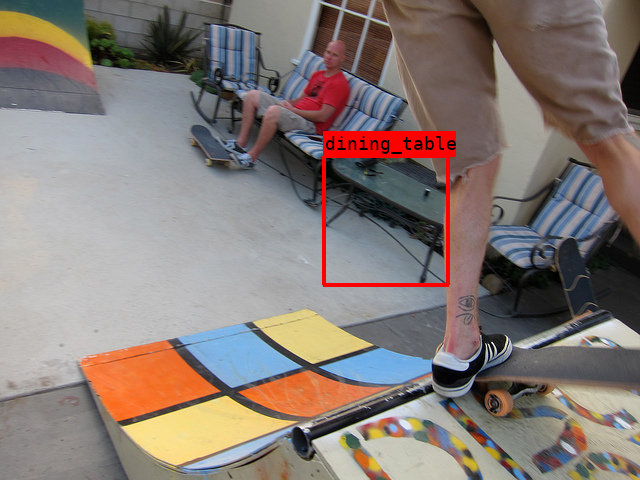

In [5]:
ind = 4

image_grps = df_partial_val.groupby('image_filepath')
image_filepaths = list(image_grps.groups.keys())
image_filepath = image_filepaths[ind]
df_image_grp = image_grps.get_group(image_filepath)
bboxes = df_image_grp[['hmin', 'wmin', 'hmax', 'wmax']].values
labels = [(nm,) for nm in df_image_grp['category_name']]
img = Image.open(image_filepath)
font_filepath = '/home/david/github_repos/fonts/DejaVuSansMono/DejaVu Sans Mono for Powerline.ttf'
draw_bounding_boxes_on_image(img, bboxes, 
                             font_size=18, font_filepath=font_filepath, 
                             display_str_list_list=labels)
img

## Load .pbtxt file

In [6]:
label_map_filepath = '../partial_v2/tfrecord/label_map.pbtxt'
label_map = label_map_util.load_labelmap(label_map_filepath)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=1000, use_display_name=True)
cat_id_map = {cat['name']: cat['id'] for cat in categories}

## Augment data with category mask info 

In [8]:
# Assign supported category id lists to image ids
df_dataset_info['labeled_cat_ids'] = df_dataset_info['cats'].apply(lambda x: cats_to_id(x, cat_id_map))
df_cats_id = (
    df_dataset_info
    .drop(columns=['cats'])
    .explode('image_ids')
    .reset_index(drop=True)
    .rename(columns={'image_ids': 'image_id'})
)

In [10]:
# Add masks to partial datasets
dataset_dfs = [df_partial_train, df_partial_val, df_partial_test]
for ind, df_dataset in enumerate(dataset_dfs):
    dataset_dfs[ind] = df_dataset.merge(df_cats_id, on='image_id', how='left')

## Serialize TFRecord datasets

In [11]:
grp_cols = ['image_id']
list_cols = ['wmin', 'wmax', 'hmin', 'hmax', 'category_name', 'category_id']
first_cols = ['image_filepath', 'labeled_cat_ids']
def get_first(vals): return vals.iloc[0]
agg_map = {**{col: list for col in list_cols}, **{col: get_first for col in first_cols}}

tfrecord_output_filepaths = [f'tfrecord/partial_{split}.record' for split in ['train', 'val', 'test']]

for output_filepath, df_dataset in zip(tfrecord_output_filepaths, dataset_dfs):
    print(output_filepath)
    df_example = df_dataset.groupby(grp_cols).agg(agg_map).reset_index().head(100)
    examples = [row for _, row in df_example.iterrows()]
    write_examples_as_tfrecord(
        examples,
        output_filepath,
        encode_object_detection_tf_example,
        num_shards=3
    )

tfrecord/partial_train.record


100%|██████████| 100/100 [00:00<00:00, 162.44it/s]


tfrecord/partial_val.record


100%|██████████| 100/100 [00:00<00:00, 202.55it/s]


tfrecord/partial_test.record


100%|██████████| 100/100 [00:00<00:00, 256.20it/s]


## Test decode 

In [15]:
from object_detection.data_decoders.tf_example_decoder import TfExampleDecoder

from partial_data.tfrecord import decode_object_detection_tf_example, read_examples_from_tfrecord

# tf_record_filepath = '/home/david/github_repos/partial-data/object_detection/datasets/partial_v2/tfrecord/complete_val.record-00000-of-00003'
tf_record_filepath = '/home/david/github_repos/partial-data/object_detection/datasets/partial_v3/tfrecord/partial_val.record-00000-of-00003'
# example_decoder = decode_object_detection_tf_example
example_decoder = TfExampleDecoder().decode
examples = read_examples_from_tfrecord(tf_record_filepath, example_decoder)

In [18]:
examples[0]['labeled_classes']

array([4, 7, 6, 3])